# Assessing auto-differentiation speed improvement

This notebooks aims to have a feeling on the speedup that can be brought by replacing classical gradient descent algorithms used in `SLITronomy` by an auto-differentiation scheme.

We wish to assess the feasability and usefulness of rewriting the loss function designed for the SLIT algorithm in a `TensorFlow` formalism, through a simple test case and timing of function evaluations.

In [1]:
__author__ = 'aymgal', ''
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
import pysap

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.plot_util import nice_colorbar

%matplotlib inline

# =========

# type of lensing operator
lensing_operator = 'interpol'  # 'interpol' or 'simple'

# number of times to subdivide source plane grid
subgrid_res_source = 2

# starlets scales
n_scales_source = 6
n_scales_lens_light = 6

# compute and reduced source plane to minimal size
minimal_source_plane = False

# use the image mask computed through noise threshold
use_threshold_mask = False

# =========


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.17.0    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

## Generate a mock lens

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel
#exp_time = 400  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    #'exposure_time': exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

(41, 41) (82, 82)


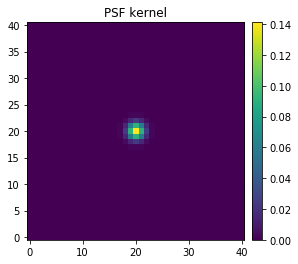

In [5]:
# PSF specification
psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
psf_kernel_hd = kernel_util.kernel_gaussian(int(psf_num_pix*subgrid_res_source), 
                                              delta_pix/subgrid_res_source, 
                                              psf_fwhm)
print(psf_kernel.shape, psf_kernel_hd.shape)
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower')
nice_colorbar(im)
plt.show()

In [6]:
lens_model_list = ['SPEMD']
kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [{'amp': 80, 'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                  'center_x': 0.1, 'center_y': 0.2}]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [{'amp': 10, 'R_sersic': 2, 'n_sersic': 3, 'e1': -0.2, 'e2': 0.1,
                      'center_x': 0, 'center_y': 0}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

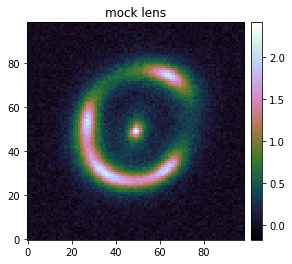

In [7]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, 
                        kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
noise = bkg # + poisson
image_sim = image_sim_no_noise + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
if kwargs_data.get('exposure_time', None) is None:
    kwargs_data['noise_map'] = background_rms * np.ones_like(image_sim)
data_class = ImageData(**kwargs_data)

plt.title("mock lens")
im = plt.imshow(image_sim, origin='lower', cmap='cubehelix')
nice_colorbar(im)
plt.show()

## Setup sparse optimizazion

In [8]:
source_model_list_sparsefit = ['STARLETS']
kwargs_starlets_source = {'n_scales': n_scales_source, 'n_pixels': np.size(image_sim)*subgrid_res_source**2}  # add center_x/center_y
kwargs_source_sparsefit = [kwargs_starlets_source]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

lens_light_model_list_sparsefit = ['STARLETS']
kwargs_starlets_lens_light = {'n_scales': n_scales_lens_light, 'n_pixels': np.size(image_sim)}  # add center_x/center_y
kwargs_lens_light_sparsefit = [kwargs_starlets_lens_light]
lens_light_model_class_sparsefit = LightModel(light_model_list=lens_light_model_list_sparsefit)

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

if use_threshold_mask:
    likelihood_mask = image_mask.astype(bool)
else:
    likelihood_mask = None

kwargs_sparse_solver = {
    'lensing_operator': lensing_operator,  # 'simple' or 'interpol'
    
    'subgrid_res_source': subgrid_res_source,
    'minimal_source_plane': minimal_source_plane,
    'min_num_pix_source': 69,
    
    'formulation': 'analysis',
    'initial_guess_type': 'noise_map',  # or 'background_rms' for just initializing with gaussian noise
    'force_positivity': True,
    'sparsity_prior_norm': 1,
    'max_threshold': 5,
    'max_threshold_high_freq': 10,
    #'num_iter': 100,  # when only source
    'num_iter_source': 100,
    'num_iter_lens': 100,
    'num_iter_weights': 1,
    'verbose': True,
    'show_steps': True,
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                lens_light_model_class=lens_light_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)


## Timings of current implementation

In [9]:
# we can isolate the solver object
solver = imageSparseFit.sparseSolver

### Compute lensing operator

In [10]:
# update manually the lensing operator
start = time.time()
solver.lensingOperator.update_mapping(kwargs_lens)
end = time.time()
print("Lensing operator building took {:e} s".format(end-start))

# Note that this operation can hardly be cast in `tensforflow` but how knows?

Lensing operator building took 5.443855e+00 s


In [11]:
# some random source and (convolved) lens light estimates
S = np.random.rand(num_pix*subgrid_res_source, num_pix*subgrid_res_source)
HG = np.random.rand(num_pix, num_pix)

### Call to the loss function

In [12]:
start = time.time()
loss = solver.loss(S=S, HG=HG)
end = time.time()
print("Single call to loss function took {:e} s".format(end-start))

Single call to loss function took 3.277063e-03 s


### Call to the gradient

In [13]:
start = time.time()
loss = solver.gradient_loss_source(S)
end = time.time()
print("Single call to loss gradient (wrt source) took {:e} s".format(end-start))

start = time.time()
loss = solver.gradient_loss_lens(HG)
end = time.time()
print("Single call to loss gradient (wrt lens) took {:e} s".format(end-start))

Single call to loss function (wrt source) took 2.785921e-03 s
Single call to loss function (wrt lens) took 3.540516e-04 s


## Comparison with `TensorFlow`'s auto-differentiation

In [14]:
# WIP